# 🚀 Proyecto ShuffleNet - Transfer Learning
## INFO1185 - Inteligencia Artificial III
### Clasificación de Vegetales con ShuffleNet V2

**Autor:** Benja Espinoza y Pablo Antivil
**Año:** 2025

---

## 📋 Descripción del Proyecto

Este proyecto implementa Transfer Learning usando **ShuffleNet V2** preentrenado en ImageNet para clasificar **5 tipos de vegetales**:

1. 🌶️ Jalapeño
2. 🌶️ Chili Pepper
3. 🥕 Carrot
4. 🌽 Corn
5. 🥒 Cucumber

### Características Principales:
- ✅ Modelo base: ShuffleNet V2 x1.0 (preentrenado en ImageNet)
- ✅ Feature extractor congelado
- ✅ Clasificador simple (1 capa FC)
- ✅ Dataset dividido en train/val/test
- ✅ Data augmentation en entrenamiento

## 📦 Paso 1: Instalación de Dependencias

**Nota:** Si estás en Google Colab, ejecuta esta celda. Si ya tienes las librerías instaladas, puedes saltarla.

In [42]:
# Instalación de paquetes necesarios
%pip install torch torchvision tqdm matplotlib numpy pillow -q

print("✅ Librerías instaladas correctamente!")

Note: you may need to restart the kernel to use updated packages.
✅ Librerías instaladas correctamente!



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 📚 Paso 2: Importar Librerías

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

print("✅ PyTorch version:", torch.__version__)
print("✅ Torchvision version:", torch.__version__)
print("✅ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ PyTorch version: 2.9.1+cpu
✅ Torchvision version: 2.9.1+cpu
✅ CUDA available: False


## 🗂️ Paso 3: Clase de Preparación de Datos

Esta clase maneja:
- Carga del dataset
- Filtrado de las 5 clases específicas
- Transformaciones (data augmentation para train, normalización para val/test)
- Creación de DataLoaders

In [44]:
class DataPreparation:
    """
    Clase para preparar y cargar el dataset.
    Filtra 5 clases específicas: jalepeno, chilli pepper, carrot, corn, cucumber.
    """
    
    def __init__(self, data_dir="./archive", batch_size=32):
        """
        Inicializa el preparador de datos.
        
        Args:
            data_dir (str): Directorio raíz del dataset (default: ./archive)
            batch_size (int): Tamaño del batch para los DataLoaders
        """
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        # Las 5 clases que necesitamos
        self.selected_classes = [
            'jalepeno',
            'chilli pepper',
            'carrot',
            'corn',
            'cucumber'
        ]
        
        # Rutas de train, val y test
        self.train_dir = os.path.join(data_dir, 'train')
        self.val_dir = os.path.join(data_dir, 'validation')
        self.test_dir = os.path.join(data_dir, 'test')
    
    def get_train_transforms(self):
        """
        Transformaciones para entrenamiento con data augmentation.
        """
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def get_val_test_transforms(self):
        """
        Transformaciones para validación y test sin augmentation.
        """
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def create_filtered_dataset(self, dataset):
        """
        Crea un dataset filtrado con labels remapeados de 0 a 4.
        
        Args:
            dataset: Dataset original de PyTorch
            
        Returns:
            tuple: (samples filtrados, mapeo de labels)
        """
        class_to_idx = dataset.class_to_idx
        
        # Obtener índices originales de las clases seleccionadas
        selected_indices = {class_to_idx[cls]: i for i, cls in enumerate(self.selected_classes) if cls in class_to_idx}
        
        # Filtrar samples y remapear labels
        filtered_samples = []
        for path, label in dataset.samples:
            if label in selected_indices:
                new_label = selected_indices[label]  # Remapear a 0-4
                filtered_samples.append((path, new_label))
        
        return filtered_samples
    
    def create_dataloaders(self):
        """
        Crea los DataLoaders para train, validation y test.
        
        Returns:
            tuple: (train_loader, val_loader, test_loader, num_classes, class_names)
        """
        print("="*70)
        print("PREPARANDO DATOS")
        print("="*70)
        
        # Crear datasets completos (sin transformaciones primero para filtrar)
        train_dataset_full = datasets.ImageFolder(root=self.train_dir)
        val_dataset_full = datasets.ImageFolder(root=self.val_dir)
        test_dataset_full = datasets.ImageFolder(root=self.test_dir)
        
        print(f"\nDataset completo:")
        print(f"   - Total de clases: {len(train_dataset_full.classes)}")
        print(f"   - Train: {len(train_dataset_full)} imágenes")
        print(f"   - Val: {len(val_dataset_full)} imágenes")
        print(f"   - Test: {len(test_dataset_full)} imágenes")
        
        # Filtrar y remapear labels
        print(f"\n🔍 Filtrando solo las 5 clases requeridas...")
        train_samples = self.create_filtered_dataset(train_dataset_full)
        val_samples = self.create_filtered_dataset(val_dataset_full)
        test_samples = self.create_filtered_dataset(test_dataset_full)
        
        print(f"\nDataset filtrado (5 clases):")
        print(f"   - Clases: {self.selected_classes}")
        print(f"   - Train: {len(train_samples)} imágenes")
        print(f"   - Val: {len(val_samples)} imágenes")
        print(f"   - Test: {len(test_samples)} imágenes")
        
        # Crear datasets con transformaciones y samples filtrados
        train_dataset = datasets.ImageFolder(root=self.train_dir, transform=self.get_train_transforms())
        train_dataset.samples = train_samples
        train_dataset.imgs = train_samples
        train_dataset.targets = [s[1] for s in train_samples]
        
        val_dataset = datasets.ImageFolder(root=self.val_dir, transform=self.get_val_test_transforms())
        val_dataset.samples = val_samples
        val_dataset.imgs = val_samples
        val_dataset.targets = [s[1] for s in val_samples]
        
        test_dataset = datasets.ImageFolder(root=self.test_dir, transform=self.get_val_test_transforms())
        test_dataset.samples = test_samples
        test_dataset.imgs = test_samples
        test_dataset.targets = [s[1] for s in test_samples]
        
        # Crear DataLoaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        print(f"\nDataLoaders creados:")
        print(f"   - Batch size: {self.batch_size}")
        print(f"   - Train batches: {len(train_loader)}")
        print(f"   - Val batches: {len(val_loader)}")
        print(f"   - Test batches: {len(test_loader)}")
        print("="*70)
        
        return train_loader, val_loader, test_loader, 5, self.selected_classes

print("Clase DataPreparation definida!")

Clase DataPreparation definida!


## 🤖 Paso 4: Definición del Modelo ShuffleNet

Clase que implementa:
- Carga de ShuffleNet V2 preentrenado en ImageNet
- Congelamiento del feature extractor
- Clasificador simple (1 capa FC, sin BatchNorm, sin Dropout)

In [45]:
class ShuffleNetSimple(nn.Module):
    """
    ShuffleNet con clasificador simple (Versión 1).
    
    Características:
    - Modelo base: ShuffleNet V2 preentrenado en ImageNet
    - Clasificador: Una sola capa Fully Connected
    - SIN BatchNorm
    - SIN Dropout
    """
    
    def __init__(self, num_classes=5, pretrained=True, freeze_features=True):
        """
        Inicializa el modelo ShuffleNet con clasificador simple.
        
        Args:
            num_classes (int): Número de clases de salida (default: 5)
            pretrained (bool): Si cargar pesos preentrenados de ImageNet (default: True)
            freeze_features (bool): Si congelar las capas convolucionales (default: True)
        """
        super(ShuffleNetSimple, self).__init__()
        
        # Cargar ShuffleNet V2 preentrenado en ImageNet
        print("Cargando ShuffleNet V2 preentrenado...")
        
        # Usar weights parameter (nuevo API de torchvision >= 0.13)
        try:
            if pretrained:
                self.shufflenet = models.shufflenet_v2_x1_0(
                    weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1
                )
            else:
                self.shufflenet = models.shufflenet_v2_x1_0(weights=None)
        except:
            # Fallback para versiones antiguas de torchvision
            self.shufflenet = models.shufflenet_v2_x1_0(pretrained=pretrained)
        
        print("ShuffleNet V2 cargado exitosamente!")
        
        # Congelar o no las capas convolucionales (feature extractor)
        if freeze_features:
            print("Congelando capas convolucionales (feature extractor)...")
            for param in self.shufflenet.parameters():
                param.requires_grad = False
            print("Capas convolucionales congeladas!")
        else:
            print("Capas convolucionales entrenable (fine-tuning completo)")
        
        # Obtener el tamaño de entrada del clasificador original
        # En ShuffleNet V2 x1.0, la última capa conv produce 1024 features
        in_features = self.shufflenet.fc.in_features
        
        # VERSIÓN 1: CLASIFICADOR SIMPLE
        # Solo una capa Fully Connected
        # SIN BatchNorm
        # SIN Dropout
        self.shufflenet.fc = nn.Linear(in_features, num_classes)
        
        print(f"\n🎯 CLASIFICADOR SIMPLE (Versión 1) creado:")
        print(f"   - Input features: {in_features}")
        print(f"   - Output classes: {num_classes}")
        print(f"   - Capas: 1 Linear")
        print(f"   - BatchNorm: NO")
        print(f"   - Dropout: NO")
    
    def forward(self, x):
        """
        Forward pass del modelo.
        
        Args:
            x (torch.Tensor): Tensor de entrada [batch_size, 3, 224, 224]
        
        Returns:
            torch.Tensor: Logits de salida [batch_size, num_classes]
        """
        return self.shufflenet(x)
    
    def get_trainable_params(self):
        """
        Obtiene los parámetros entrenables del modelo.
        
        Returns:
            list: Lista de parámetros que requieren gradiente
        """
        return [p for p in self.parameters() if p.requires_grad]
    
    def count_parameters(self):
        """
        Cuenta los parámetros del modelo.
        
        Returns:
            dict: Diccionario con total, entrenables y congelados
        """
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        return {
            'total': total_params,
            'trainable': trainable_params,
            'frozen': frozen_params
        }
    
    def print_model_info(self):
        """
        Imprime información detallada del modelo.
        """
        params = self.count_parameters()
        print("\n" + "="*60)
        print("INFORMACIÓN DEL MODELO")
        print("="*60)
        print(f"Parámetros totales:      {params['total']:,}")
        print(f"Parámetros entrenables:  {params['trainable']:,}")
        print(f"Parámetros congelados:   {params['frozen']:,}")
        print(f"Porcentaje entrenable:   {params['trainable']/params['total']*100:.2f}%")
        print("="*60)

print("✅ Clase ShuffleNetSimple definida!")

✅ Clase ShuffleNetSimple definida!


## ⚙️ Paso 5: Configuración de Parámetros

Definimos todos los hiperparámetros del entrenamiento.

In [ ]:
# ==========================================
# CONFIGURACIÓN
# ==========================================

# Ruta del dataset
DATA_DIR = "./archive"  # Cambiar si es necesario

# Parámetros del modelo
NUM_CLASSES = 5  # jalepeno, chilli pepper, carrot, corn, cucumber

# Hiperparámetros de entrenamiento
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

# Dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("="*70)
print("📋 CONFIGURACIÓN DEL PROYECTO")
print("="*70)
print(f"Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print(f"Clases: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Épocas: {NUM_EPOCHS}")
print("="*70)

📋 CONFIGURACIÓN DEL PROYECTO
Dispositivo: cpu
Clases: 5
Batch size: 32
Learning rate: 0.001
Épocas: 10


## 📥 Paso 6: Cargar Datos

Creamos los DataLoaders para entrenamiento, validación y prueba.

In [47]:
# Crear instancia de DataPreparation
data_prep = DataPreparation(data_dir=DATA_DIR, batch_size=BATCH_SIZE)

# Crear DataLoaders
train_loader, val_loader, test_loader, num_classes, class_names = data_prep.create_dataloaders()

print("\nDatos cargados exitosamente!")
print(f"   Clases: {class_names}")

PREPARANDO DATOS

Dataset completo:
   - Total de clases: 36
   - Train: 3115 imágenes
   - Val: 351 imágenes
   - Test: 359 imágenes

🔍 Filtrando solo las 5 clases requeridas...

Dataset filtrado (5 clases):
   - Clases: ['jalepeno', 'chilli pepper', 'carrot', 'corn', 'cucumber']
   - Train: 438 imágenes
   - Val: 47 imágenes
   - Test: 50 imágenes

DataLoaders creados:
   - Batch size: 32
   - Train batches: 14
   - Val batches: 2
   - Test batches: 2

Datos cargados exitosamente!
   Clases: ['jalepeno', 'chilli pepper', 'carrot', 'corn', 'cucumber']


## 🏗️ Paso 7: Crear Modelo

Inicializamos el modelo ShuffleNet y lo movemos al dispositivo (GPU/CPU).

In [48]:
# Crear modelo
model = ShuffleNetSimple(
    num_classes=NUM_CLASSES,
    pretrained=True,
    freeze_features=True
)

# Mostrar información del modelo
model.print_model_info()

# Mover modelo al dispositivo
model = model.to(device)
print(f"\nModelo movido a {device}")

Cargando ShuffleNet V2 preentrenado...
ShuffleNet V2 cargado exitosamente!
Congelando capas convolucionales (feature extractor)...
Capas convolucionales congeladas!

🎯 CLASIFICADOR SIMPLE (Versión 1) creado:
   - Input features: 1024
   - Output classes: 5
   - Capas: 1 Linear
   - BatchNorm: NO
   - Dropout: NO

INFORMACIÓN DEL MODELO
Parámetros totales:      1,258,729
Parámetros entrenables:  5,125
Parámetros congelados:   1,253,604
Porcentaje entrenable:   0.41%

Modelo movido a cpu


## 🎯 Paso 8: Configurar Entrenamiento

Definimos la función de pérdida, optimizador y scheduler.

In [49]:
# Función de pérdida
criterion = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

# Optimizador (solo para parámetros entrenables)
optimizer = optim.Adam(model.get_trainable_params(), lr=LEARNING_RATE)
print(f"Optimizer: Adam (lr={LEARNING_RATE})")

# Scheduler (opcional - reduce LR cada 5 épocas)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
print("Scheduler: StepLR (step=5, gamma=0.1)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step=5, gamma=0.1)


## 🔄 Paso 9: Funciones de Entrenamiento y Validación

In [50]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo por una época.
    
    Args:
        model: Modelo a entrenar
        train_loader: DataLoader de entrenamiento
        criterion: Función de pérdida
        optimizer: Optimizador
        device: Dispositivo (cuda/cpu)
    
    Returns:
        tuple: (loss promedio, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc="Entrenando", leave=False)
    
    for images, labels in pbar:
        # Mover datos al dispositivo
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Actualizar progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """
    Valida el modelo.
    
    Args:
        model: Modelo a validar
        val_loader: DataLoader de validación
        criterion: Función de pérdida
        device: Dispositivo (cuda/cpu)
    
    Returns:
        tuple: (loss promedio, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            # Mover datos al dispositivo
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Estadísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Funciones de entrenamiento y validación definidas!")

✅ Funciones de entrenamiento y validación definidas!


## 🚀 Paso 10: Loop de Entrenamiento

Entrenamos el modelo durante el número de épocas especificado.

In [51]:
# ==========================================
# ENTRENAMIENTO VERSIÓN 1 CON TRUE EARLY STOPPING
# ==========================================

# Listas para guardar métricas
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("="*70)
print("INICIANDO ENTRENAMIENTO V1 CON TRUE EARLY STOPPING")
print("="*70)

best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0
early_stop = False
patience = 3  # Misma paciencia que las otras versiones

for epoch in range(NUM_EPOCHS):
    if early_stop:
        print(f"🛑 EARLY STOPPING ACTIVADO en época {epoch+1}")
        break
        
    print(f"\n📍 Época {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Entrenamiento
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validación
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Actualizar learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # EARLY STOPPING LOGIC - IGUAL QUE V2A Y V2B
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        epochs_no_improve = 0  # Reset counter
        print(f"🌟 ¡Nuevo mejor modelo! Val Acc: {best_val_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"⏳ Sin mejora por {epochs_no_improve}/{patience} épocas")
        
        if epochs_no_improve >= patience:
            early_stop = True
    
    # Imprimir resultados
    print(f"✅ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"✅ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"📊 Learning Rate: {current_lr:.6f}")

print("\n" + "="*70)
print("ENTRENAMIENTO COMPLETADO")
if early_stop:
    print(f"Detenido temprano en época {epoch+1}")
else:
    print(f"Completadas todas las {NUM_EPOCHS} épocas")
print("="*70)
print(f"Mejor Val Accuracy: {best_val_acc:.2f}%")
# Cargar el mejor modelo
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Mejor modelo cargado para evaluación")
# Guardar el número de épocas realmente ejecutadas
num_epochs_run_v1 = epoch + 1 if early_stop else NUM_EPOCHS
print(f"Épocas ejecutadas: {num_epochs_run_v1}")

INICIANDO ENTRENAMIENTO V1 CON TRUE EARLY STOPPING

📍 Época 1/10
----------------------------------------------------------------------


Entrenando:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\pablo\OneDrive\Documentos\UCT\GitHub\INFO1185-Proyecto3-ShuffleNet\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🌟 ¡Nuevo mejor modelo! Val Acc: 34.04%
✅ Train Loss: 1.5920 | Train Acc: 22.60%
✅ Val Loss:   1.5600 | Val Acc:   34.04%
📊 Learning Rate: 0.001000

📍 Época 2/10
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 76.60%
✅ Train Loss: 1.5578 | Train Acc: 41.32%
✅ Val Loss:   1.5235 | Val Acc:   76.60%
📊 Learning Rate: 0.001000

📍 Época 3/10
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 82.98%
✅ Train Loss: 1.5244 | Train Acc: 62.79%
✅ Val Loss:   1.4882 | Val Acc:   82.98%
📊 Learning Rate: 0.001000

📍 Época 4/10
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 1.4950 | Train Acc: 69.18%
✅ Val Loss:   1.4543 | Val Acc:   82.98%
📊 Learning Rate: 0.001000

📍 Época 5/10
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 85.11%
✅ Train Loss: 1.4666 | Train Acc: 73.74%
✅ Val Loss:   1.4188 | Val Acc:   85.11%
📊 Learning Rate: 0.000100

📍 Época 6/10
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 1.4479 | Train Acc: 76.94%
✅ Val Loss:   1.4128 | Val Acc:   85.11%
📊 Learning Rate: 0.000100

📍 Época 7/10
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 87.23%
✅ Train Loss: 1.4433 | Train Acc: 80.14%
✅ Val Loss:   1.4090 | Val Acc:   87.23%
📊 Learning Rate: 0.000100

📍 Época 8/10
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 1.4378 | Train Acc: 78.08%
✅ Val Loss:   1.4092 | Val Acc:   85.11%
📊 Learning Rate: 0.000100

📍 Época 9/10
----------------------------------------------------------------------


⏳ Sin mejora por 2/3 épocas
✅ Train Loss: 1.4431 | Train Acc: 79.00%
✅ Val Loss:   1.4080 | Val Acc:   87.23%
📊 Learning Rate: 0.000100

📍 Época 10/10
----------------------------------------------------------------------


⏳ Sin mejora por 3/3 épocas
✅ Train Loss: 1.4338 | Train Acc: 77.63%
✅ Val Loss:   1.4026 | Val Acc:   85.11%
📊 Learning Rate: 0.000010

ENTRENAMIENTO COMPLETADO
Detenido temprano en época 10
Mejor Val Accuracy: 87.23%
Mejor modelo cargado para evaluación
Épocas ejecutadas: 10


## 📊 Paso 11: Visualizar Curvas de Entrenamiento

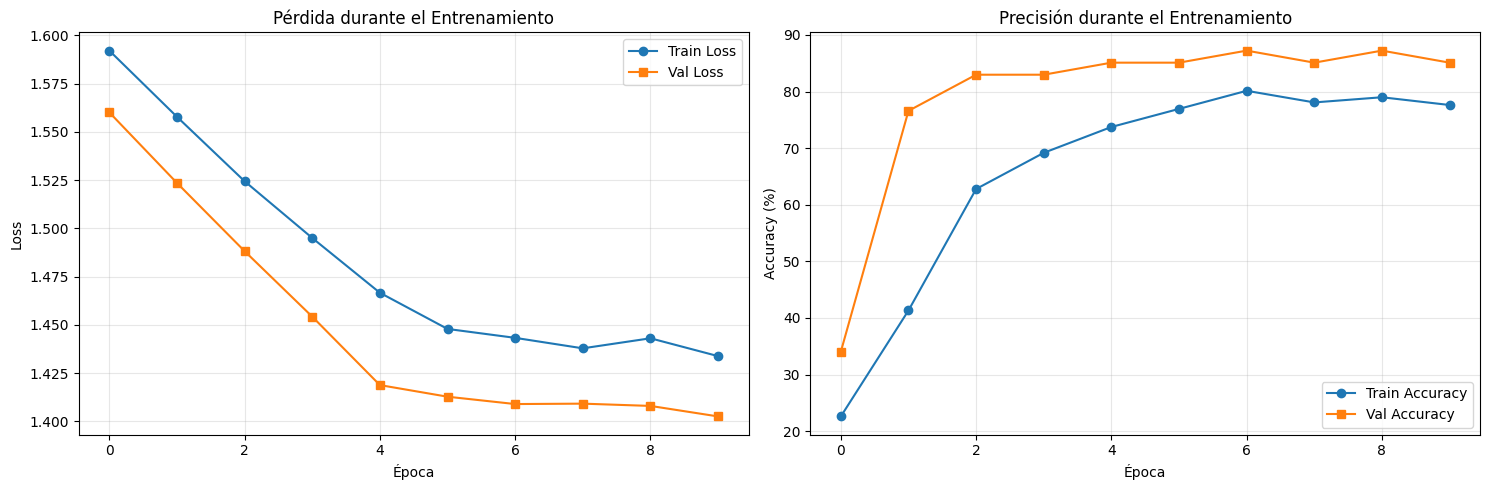

✅ Curvas de entrenamiento visualizadas!


In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Loss
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pérdida durante el Entrenamiento')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de Accuracy
axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(val_accs, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Precisión durante el Entrenamiento')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Curvas de entrenamiento visualizadas!")

## 🧪 Paso 12: Evaluación en el Conjunto de Test

In [53]:
print("="*70)
print("EVALUACIÓN EN TEST SET")
print("="*70)

# Evaluar en test
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*70)

EVALUACIÓN EN TEST SET

Test Loss: 1.4057
Test Accuracy: 84.00%


## 📈 Paso 13: Matriz de Confusión

Visualizamos el desempeño del modelo en cada clase.

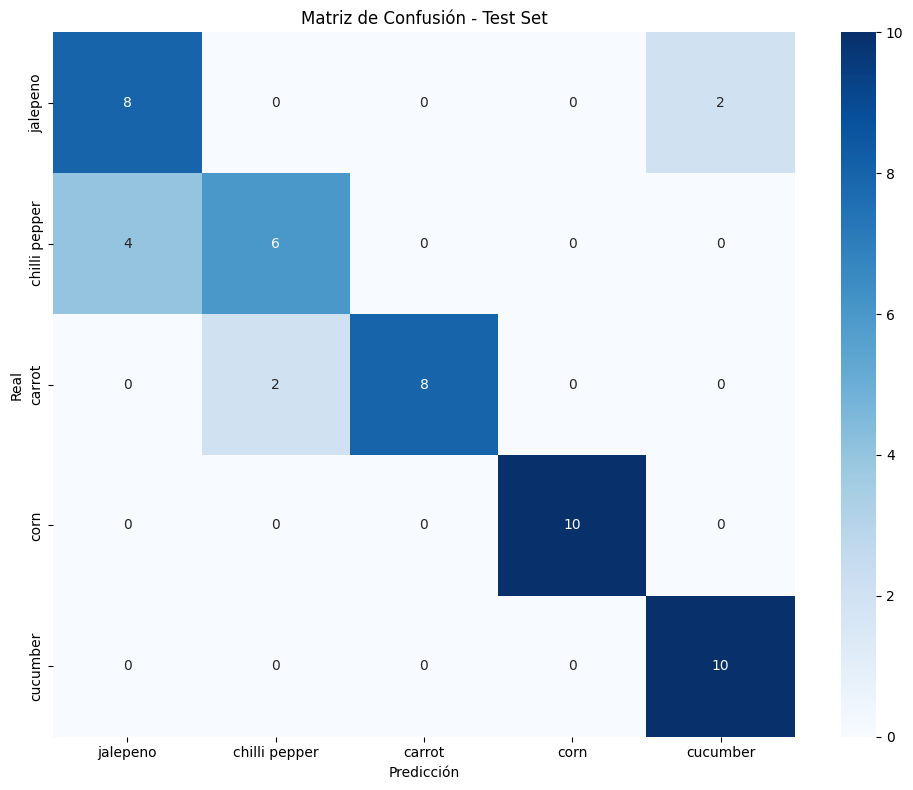


REPORTE DE CLASIFICACIÓN
               precision    recall  f1-score   support

     jalepeno     0.6667    0.8000    0.7273        10
chilli pepper     0.7500    0.6000    0.6667        10
       carrot     1.0000    0.8000    0.8889        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     0.8333    1.0000    0.9091        10

     accuracy                         0.8400        50
    macro avg     0.8500    0.8400    0.8384        50
 weighted avg     0.8500    0.8400    0.8384        50



In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Obtener predicciones en test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Crear matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test Set')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN")
print("="*70)
print(classification_report(all_labels, all_preds, 
                          target_names=class_names, 
                          digits=4))
print("="*70)

## 💾 Paso 14: Guardar el Modelo

Guardamos el modelo entrenado para uso futuro.

In [55]:
# Guardar el modelo completo
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_acc': test_acc,
    'test_loss': test_loss,
    'class_names': class_names,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE
}, 'shufflenet_modelo_final.pth')

print("✅ Modelo guardado como 'shufflenet_modelo_final.pth'")

✅ Modelo guardado como 'shufflenet_modelo_final.pth'


## 🎉 Paso 15: Resumen Final del Proyecto

Mostramos un resumen completo de los resultados obtenidos.

In [56]:
print("\n🔵 CONFIGURACIÓN:")
print(f"   • Modelo base: ShuffleNet V2 x1.0 (ImageNet)")
print(f"   • Clases: {NUM_CLASSES} vegetales")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Learning rate inicial: {LEARNING_RATE}")
print(f"   • Épocas: {NUM_EPOCHS}")
print(f"   • Dispositivo: {device}")

print("\n🔵 DATASET:")
print(f"   • Clases: {', '.join(class_names)}")
print(f"   • Train: {len(train_loader.dataset)} imágenes")
print(f"   • Validation: {len(val_loader.dataset)} imágenes")
print(f"   • Test: {len(test_loader.dataset)} imágenes")

print("\n🔵 ARQUITECTURA:")
params = model.count_parameters()
print(f"   • Parámetros totales: {params['total']:,}")
print(f"   • Parámetros entrenables: {params['trainable']:,} ({params['trainable']/params['total']*100:.2f}%)")
print(f"   • Feature extractor: Congelado")
print(f"   • Clasificador: 1 capa FC (simple)")

print("\n🔵 RESULTADOS FINALES:")
print(f"   • Mejor Val Accuracy: {best_val_acc:.2f}%")
print(f"   • Test Accuracy: {test_acc:.2f}%")
print(f"   • Test Loss: {test_loss:.4f}")

print("\n🔵 ARCHIVOS GENERADOS:")
print(f"   • Modelo guardado: shufflenet_modelo_final.pth")


🔵 CONFIGURACIÓN:
   • Modelo base: ShuffleNet V2 x1.0 (ImageNet)
   • Clases: 5 vegetales
   • Batch size: 32
   • Learning rate inicial: 0.001
   • Épocas: 10
   • Dispositivo: cpu

🔵 DATASET:
   • Clases: jalepeno, chilli pepper, carrot, corn, cucumber
   • Train: 438 imágenes
   • Validation: 47 imágenes
   • Test: 50 imágenes

🔵 ARQUITECTURA:
   • Parámetros totales: 1,258,729
   • Parámetros entrenables: 5,125 (0.41%)
   • Feature extractor: Congelado
   • Clasificador: 1 capa FC (simple)

🔵 RESULTADOS FINALES:
   • Mejor Val Accuracy: 87.23%
   • Test Accuracy: 84.00%
   • Test Loss: 1.4057

🔵 ARCHIVOS GENERADOS:
   • Modelo guardado: shufflenet_modelo_final.pth


In [57]:
class ShuffleNetExtended(nn.Module):
    """
    ShuffleNet con clasificador extendido (Versión 2).
    
    Características:
    - Modelo base: ShuffleNet V2 preentrenado en ImageNet
    - Clasificador: Múltiples capas Fully Connected en forma de embudo
    - Opcional: BatchNorm y Dropout (para variante 2B)
    """
    
    def __init__(self, num_classes=5, pretrained=True, freeze_features=True, 
                 use_batchnorm=False, use_dropout=False, dropout_prob=0.3):
        """
        Inicializa el modelo ShuffleNet con clasificador extendido.
        
        Args:
            num_classes (int): Número de clases de salida (default: 5)
            pretrained (bool): Si cargar pesos preentrenados de ImageNet (default: True)
            freeze_features (bool): Si congelar las capas convolucionales (default: True)
            use_batchnorm (bool): Si usar BatchNorm en las capas ocultas (default: False)
            use_dropout (bool): Si usar Dropout en las capas ocultas (default: False)
            dropout_prob (float): Probabilidad de Dropout (default: 0.3)
        """
        super(ShuffleNetExtended, self).__init__()
        
        # Cargar ShuffleNet V2 preentrenado en ImageNet
        print("Cargando ShuffleNet V2 preentrenado...")
        
        try:
            if pretrained:
                self.shufflenet = models.shufflenet_v2_x1_0(
                    weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1
                )
            else:
                self.shufflenet = models.shufflenet_v2_x1_0(weights=None)
        except:
            # Fallback para versiones antiguas de torchvision
            self.shufflenet = models.shufflenet_v2_x1_0(pretrained=pretrained)
        
        print("ShuffleNet V2 cargado exitosamente!")
        
        # Congelar o no las capas convolucionales (feature extractor)
        if freeze_features:
            print("Congelando capas convolucionales (feature extractor)...")
            for param in self.shufflenet.parameters():
                param.requires_grad = False
            print("Capas convolucionales congeladas!")
        else:
            print("Capas convolucionales entrenable (fine-tuning completo)")
        
        # Obtener el tamaño de entrada del clasificador original
        in_features = self.shufflenet.fc.in_features
        
        # VERSIÓN 2: CLASIFICADOR EXTENDIDO
        # Construimos un clasificador con al menos dos capas ocultas en forma de embudo
        # Ejemplo: 512 -> 256 -> 128 -> num_classes
        layers = []
        
        # Capa 1: 1024 (in_features) -> 512
        layers.append(nn.Linear(in_features, 512))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(512))
        layers.append(nn.ReLU(inplace=True))
        if use_dropout:
            layers.append(nn.Dropout(p=dropout_prob))
        
        # Capa 2: 512 -> 256
        layers.append(nn.Linear(512, 256))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(256))
        layers.append(nn.ReLU(inplace=True))
        if use_dropout:
            layers.append(nn.Dropout(p=dropout_prob))
        
        # Capa 3: 256 -> 128
        layers.append(nn.Linear(256, 128))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(128))
        layers.append(nn.ReLU(inplace=True))
        if use_dropout:
            layers.append(nn.Dropout(p=dropout_prob))
        
        # Capa de salida: 128 -> num_classes
        layers.append(nn.Linear(128, num_classes))
        
        # Construir el clasificador como una secuencia de capas
        self.classifier = nn.Sequential(*layers)
        
        # Reemplazar el clasificador original de ShuffleNet por nuestro clasificador extendido
        self.shufflenet.fc = self.classifier
        
        # Configuración para imprimir
        self.config_str = f"""
  CLASIFICADOR EXTENDIDO (Versión 2) creado:
   - Input features: {in_features}
   - Output classes: {num_classes}
   - Arquitectura: 1024 -> 512 -> 256 -> 128 -> {num_classes}
   - BatchNorm: {'SI' if use_batchnorm else 'NO'}
   - Dropout: {'SI' if use_dropout else 'NO'} (p={dropout_prob if use_dropout else 'N/A'})
"""
        print(self.config_str)
    
    def forward(self, x):
        """
        Forward pass del modelo.
        
        Args:
            x (torch.Tensor): Tensor de entrada [batch_size, 3, 224, 224]
        
        Returns:
            torch.Tensor: Logits de salida [batch_size, num_classes]
        """
        return self.shufflenet(x)
    
    def get_trainable_params(self):
        """
        Obtiene los parámetros entrenables del modelo.
        
        Returns:
            list: Lista de parámetros que requieren gradiente
        """
        return [p for p in self.parameters() if p.requires_grad]
    
    def count_parameters(self):
        """
        Cuenta los parámetros del modelo.
        
        Returns:
            dict: Diccionario con total, entrenables y congelados
        """
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        return {
            'total': total_params,
            'trainable': trainable_params,
            'frozen': frozen_params
        }
    
    def print_model_info(self):
        """
        Imprime información detallada del modelo.
        """
        params = self.count_parameters()
        print("\n" + "="*60)
        print("INFORMACIÓN DEL MODELO")
        print("="*60)
        print(f"Parámetros totales:      {params['total']:,}")
        print(f"Parámetros entrenables:  {params['trainable']:,}")
        print(f"Parámetros congelados:   {params['frozen']:,}")
        print(f"Porcentaje entrenable:   {params['trainable']/params['total']*100:.2f}%")
        print("="*60)

print("✅ Clase ShuffleNetExtended definida!")

✅ Clase ShuffleNetExtended definida!


In [58]:
# ==========================================
# CONFIGURACIÓN VERSIÓN 2A - SIN REGULARIZACIÓN
# ==========================================

print("="*70)
print("CREANDO VERSIÓN 2A - SIN BATCHNORM Y SIN DROPOUT")
print("="*70)

# Crear modelo Versión 2A
model_v2a = ShuffleNetExtended(
    num_classes=NUM_CLASSES,
    pretrained=True,
    freeze_features=True,
    use_batchnorm=False,    # Sin BatchNorm
    use_dropout=False       # Sin Dropout
)

# Mostrar información del modelo
model_v2a.print_model_info()

# Mover modelo al dispositivo
model_v2a = model_v2a.to(device)
print(f"\nModelo Versión 2A movido a {device}")

CREANDO VERSIÓN 2A - SIN BATCHNORM Y SIN DROPOUT
Cargando ShuffleNet V2 preentrenado...
ShuffleNet V2 cargado exitosamente!
Congelando capas convolucionales (feature extractor)...
Capas convolucionales congeladas!

  CLASIFICADOR EXTENDIDO (Versión 2) creado:
   - Input features: 1024
   - Output classes: 5
   - Arquitectura: 1024 -> 512 -> 256 -> 128 -> 5
   - BatchNorm: NO
   - Dropout: NO (p=N/A)


INFORMACIÓN DEL MODELO
Parámetros totales:      1,943,273
Parámetros entrenables:  689,669
Parámetros congelados:   1,253,604
Porcentaje entrenable:   35.49%

Modelo Versión 2A movido a cpu


In [59]:
# ==========================================
# ENTRENAMIENTO VERSIÓN 2A
# ==========================================

# Función de pérdida
criterion_v2a = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

# Optimizador (solo para parámetros entrenables)
optimizer_v2a = optim.Adam(model_v2a.get_trainable_params(), lr=LEARNING_RATE)
print(f"Optimizer: Adam (lr={LEARNING_RATE})")

# Scheduler (opcional - reduce LR cada 5 épocas)
scheduler_v2a = optim.lr_scheduler.StepLR(optimizer_v2a, step_size=5, gamma=0.1)
print("Scheduler: StepLR (step=5, gamma=0.1)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step=5, gamma=0.1)


In [60]:
# ==========================================
# ENTRENAMIENTO VERSIÓN 2A CON TRUE EARLY STOPPING
# ==========================================

def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5):
    """
    Entrenamiento con true early stopping.
    
    Args:
        patience (int): Número de épocas sin mejora antes de detener
        num_epochs (int): Máximo número de épocas (ahora más alto por si acaso)
    """
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0
    early_stop = False
    
    print("="*70)
    print("INICIANDO ENTRENAMIENTO CON TRUE EARLY STOPPING")
    print(f"🛑 Patiencia: {patience} épocas sin mejora")
    print(f"📅 Máximo de épocas: {num_epochs}")
    print("="*70)
    
    for epoch in range(num_epochs):
        if early_stop:
            print(f"🛑 EARLY STOPPING ACTIVADO en época {epoch+1}")
            break
            
        print(f"\n📍 Época {epoch+1}/{num_epochs}")
        print("-" * 70)
        
        # Entrenamiento
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validación
        val_loss, val_acc = validate(
            model, val_loader, criterion, device
        )
        
        # Guardar métricas
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Actualizar learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # EARLY STOPPING LOGIC
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0  # Reset counter
            print(f"🌟 ¡Nuevo mejor modelo! Val Acc: {best_val_acc:.2f}%")
        else:
            epochs_no_improve += 1
            print(f"⏳ Sin mejora por {epochs_no_improve}/{patience} épocas")
            
            if epochs_no_improve >= patience:
                early_stop = True
        
        # Imprimir resultados
        print(f"✅ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"✅ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"📊 Learning Rate: {current_lr:.6f}")
    
    print("\n" + "="*70)
    print("✅ ENTRENAMIENTO COMPLETADO")
    if early_stop:
        print(f"🛑 Detenido temprano en época {epoch+1}")
    else:
        print(f"📅 Completadas todas las {num_epochs} épocas")
    print("="*70)
    print(f"🏆 Mejor Val Accuracy: {best_val_acc:.2f}%")
    
    # Cargar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("✅ Mejor modelo cargado para evaluación")
    
    return train_losses, train_accs, val_losses, val_accs, best_val_acc, epoch+1

# Ahora entrenamos la V2A con true early stopping
print("="*70)
print("INICIANDO ENTRENAMIENTO - VERSIÓN 2A CON TRUE EARLY STOPPING")
print("="*70)

# Reiniciamos el modelo V2A para empezar desde cero
model_v2a = ShuffleNetExtended(
    num_classes=NUM_CLASSES,
    pretrained=True,
    freeze_features=True,
    use_batchnorm=False,    # Sin BatchNorm
    use_dropout=False       # Sin Dropout
).to(device)

# Configuración de optimizer y scheduler para el nuevo modelo
optimizer_v2a = optim.Adam(model_v2a.get_trainable_params(), lr=LEARNING_RATE)
scheduler_v2a = optim.lr_scheduler.StepLR(optimizer_v2a, step_size=5, gamma=0.1)

# Entrenar con early stopping
train_losses_v2a, train_accs_v2a, val_losses_v2a, val_accs_v2a, best_val_acc_v2a, num_epochs_run = train_with_early_stopping(
    model=model_v2a,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_v2a,
    optimizer=optimizer_v2a,
    scheduler=scheduler_v2a,
    device=device,
    num_epochs=50,  # Más épocas por si acaso
    patience=3      # 3 épocas sin mejora -> stop
)

INICIANDO ENTRENAMIENTO - VERSIÓN 2A CON TRUE EARLY STOPPING
Cargando ShuffleNet V2 preentrenado...
ShuffleNet V2 cargado exitosamente!
Congelando capas convolucionales (feature extractor)...
Capas convolucionales congeladas!

  CLASIFICADOR EXTENDIDO (Versión 2) creado:
   - Input features: 1024
   - Output classes: 5
   - Arquitectura: 1024 -> 512 -> 256 -> 128 -> 5
   - BatchNorm: NO
   - Dropout: NO (p=N/A)

INICIANDO ENTRENAMIENTO CON TRUE EARLY STOPPING
🛑 Patiencia: 3 épocas sin mejora
📅 Máximo de épocas: 50

📍 Época 1/50
----------------------------------------------------------------------


Entrenando:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\pablo\OneDrive\Documentos\UCT\GitHub\INFO1185-Proyecto3-ShuffleNet\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🌟 ¡Nuevo mejor modelo! Val Acc: 76.60%
✅ Train Loss: 1.5885 | Train Acc: 32.88%
✅ Val Loss:   1.5172 | Val Acc:   76.60%
📊 Learning Rate: 0.001000

📍 Época 2/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 87.23%
✅ Train Loss: 1.3512 | Train Acc: 69.41%
✅ Val Loss:   0.9667 | Val Acc:   87.23%
📊 Learning Rate: 0.001000

📍 Época 3/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 91.49%
✅ Train Loss: 0.8375 | Train Acc: 72.15%
✅ Val Loss:   0.4284 | Val Acc:   91.49%
📊 Learning Rate: 0.001000

📍 Época 4/50
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 0.5707 | Train Acc: 80.59%
✅ Val Loss:   0.3176 | Val Acc:   87.23%
📊 Learning Rate: 0.001000

📍 Época 5/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 93.62%
✅ Train Loss: 0.5372 | Train Acc: 79.45%
✅ Val Loss:   0.2361 | Val Acc:   93.62%
📊 Learning Rate: 0.000100

📍 Época 6/50
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 0.4404 | Train Acc: 83.79%
✅ Val Loss:   0.2295 | Val Acc:   93.62%
📊 Learning Rate: 0.000100

📍 Época 7/50
----------------------------------------------------------------------


⏳ Sin mejora por 2/3 épocas
✅ Train Loss: 0.4053 | Train Acc: 86.99%
✅ Val Loss:   0.2298 | Val Acc:   93.62%
📊 Learning Rate: 0.000100

📍 Época 8/50
----------------------------------------------------------------------


⏳ Sin mejora por 3/3 épocas
✅ Train Loss: 0.4202 | Train Acc: 83.33%
✅ Val Loss:   0.2144 | Val Acc:   93.62%
📊 Learning Rate: 0.000100
🛑 EARLY STOPPING ACTIVADO en época 9

✅ ENTRENAMIENTO COMPLETADO
🛑 Detenido temprano en época 9
🏆 Mejor Val Accuracy: 93.62%
✅ Mejor modelo cargado para evaluación


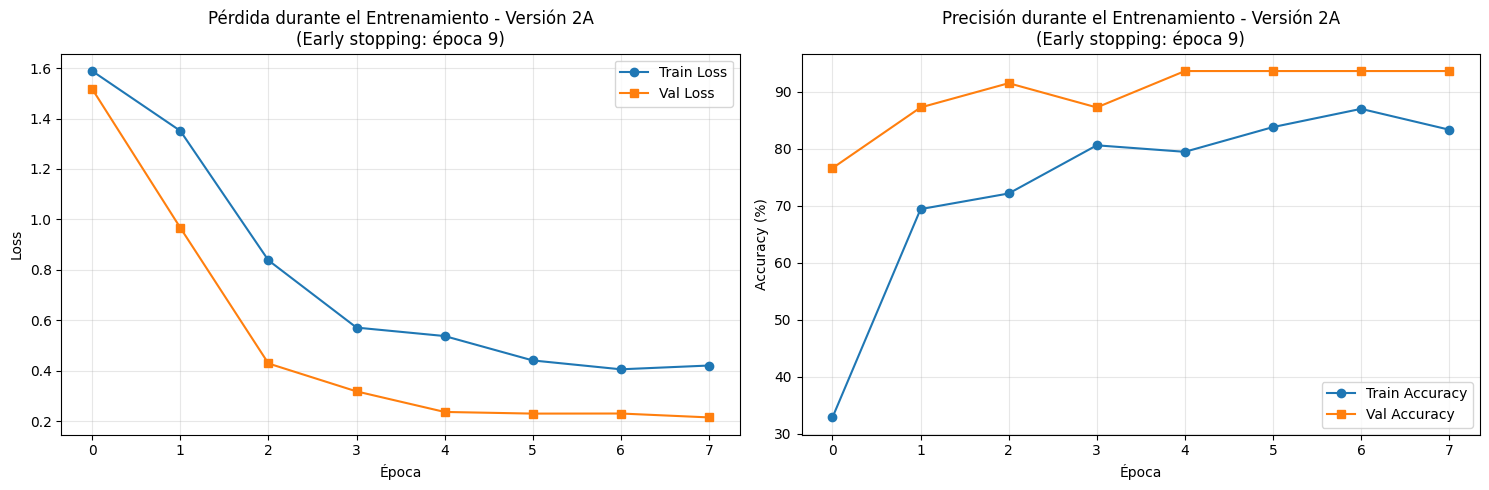

✅ Curvas de entrenamiento de la Versión 2A con Early Stopping visualizadas!


In [61]:
# ==========================================
# CURVAS DE ENTRENAMIENTO - VERSIÓN 2A CON EARLY STOPPING
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Loss
axes[0].plot(train_losses_v2a, label='Train Loss', marker='o')
axes[0].plot(val_losses_v2a, label='Val Loss', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Pérdida durante el Entrenamiento - Versión 2A\n(Early stopping: época {num_epochs_run})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de Accuracy
axes[1].plot(train_accs_v2a, label='Train Accuracy', marker='o')
axes[1].plot(val_accs_v2a, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title(f'Precisión durante el Entrenamiento - Versión 2A\n(Early stopping: época {num_epochs_run})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Curvas de entrenamiento de la Versión 2A con Early Stopping visualizadas!")

In [62]:
# ==========================================
# EVALUACIÓN EN TEST SET - VERSIÓN 2A
# ==========================================

print("="*70)
print("EVALUACIÓN EN TEST SET - VERSIÓN 2A")
print("="*70)

# Evaluar en test
test_loss_v2a, test_acc_v2a = validate(model_v2a, test_loader, criterion_v2a, device)

print(f"\nTest Loss: {test_loss_v2a:.4f}")
print(f"Test Accuracy: {test_acc_v2a:.2f}%")
print("="*70)

EVALUACIÓN EN TEST SET - VERSIÓN 2A

Test Loss: 0.2238
Test Accuracy: 92.00%


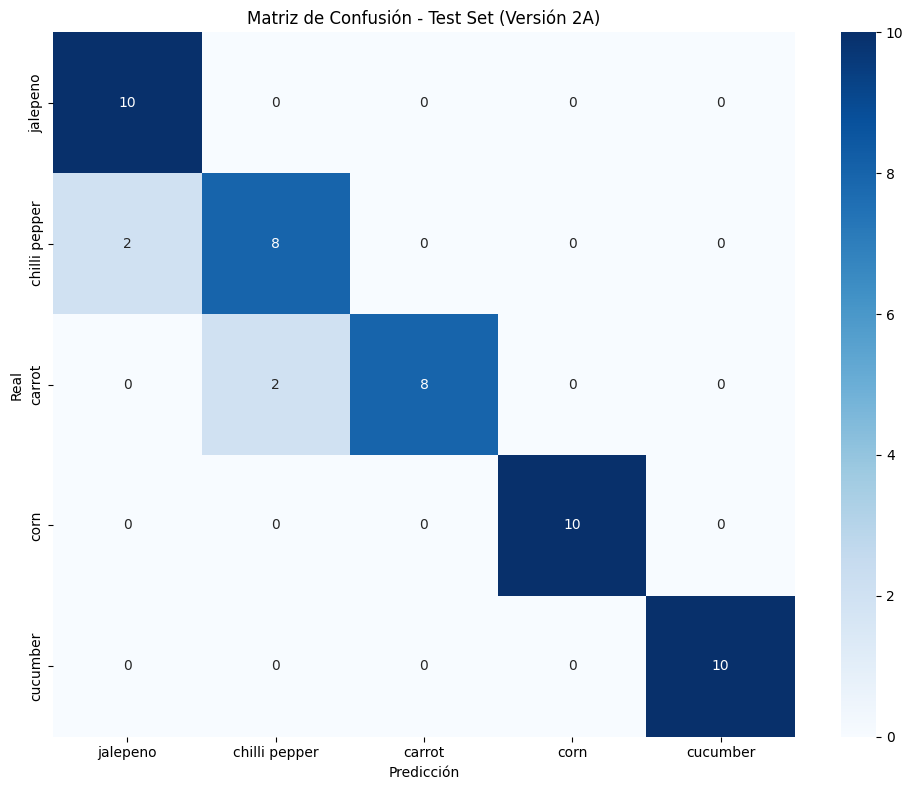


REPORTE DE CLASIFICACIÓN - VERSIÓN 2A
               precision    recall  f1-score   support

     jalepeno     0.8333    1.0000    0.9091        10
chilli pepper     0.8000    0.8000    0.8000        10
       carrot     1.0000    0.8000    0.8889        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10

     accuracy                         0.9200        50
    macro avg     0.9267    0.9200    0.9196        50
 weighted avg     0.9267    0.9200    0.9196        50



In [63]:
# ==========================================
# MATRIZ DE CONFUSIÓN Y REPORTE - VERSIÓN 2A
# ==========================================

# Obtener predicciones en test set
model_v2a.eval()
all_preds_v2a = []
all_labels_v2a = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_v2a(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds_v2a.extend(predicted.cpu().numpy())
        all_labels_v2a.extend(labels.numpy())

# Crear matriz de confusión
cm_v2a = confusion_matrix(all_labels_v2a, all_preds_v2a)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_v2a, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test Set (Versión 2A)')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN - VERSIÓN 2A")
print("="*70)
print(classification_report(all_labels_v2a, all_preds_v2a, 
                          target_names=class_names, 
                          digits=4))
print("="*70)

In [64]:
# Guardar el modelo de la Versión 2A
torch.save({
    'model_state_dict': model_v2a.state_dict(),
    'optimizer_state_dict': optimizer_v2a.state_dict(),
    'train_losses': train_losses_v2a,
    'train_accs': train_accs_v2a,
    'val_losses': val_losses_v2a,
    'val_accs': val_accs_v2a,
    'test_acc': test_acc_v2a,
    'test_loss': test_loss_v2a,
    'class_names': class_names,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'version': '2A'
}, 'shufflenet_version_2a.pth')

print("✅ Modelo Versión 2A guardado como 'shufflenet_version_2a.pth'")

✅ Modelo Versión 2A guardado como 'shufflenet_version_2a.pth'


In [65]:
# ==========================================
# CONFIGURACIÓN VERSIÓN 2B - CON REGULARIZACIÓN
# ==========================================

print("="*70)
print("CREANDO VERSIÓN 2B - CON BATCHNORM Y DROPOUT")
print("="*70)

# Crear modelo Versión 2B
model_v2b = ShuffleNetExtended(
    num_classes=NUM_CLASSES,
    pretrained=True,
    freeze_features=True,
    use_batchnorm=True,     # CON BatchNorm
    use_dropout=True,       # CON Dropout
    dropout_prob=0.3        # Probabilidad de dropout
)

# Mostrar información del modelo
model_v2b.print_model_info()

# Mover modelo al dispositivo
model_v2b = model_v2b.to(device)
print(f"\nModelo Versión 2B movido a {device}")

CREANDO VERSIÓN 2B - CON BATCHNORM Y DROPOUT
Cargando ShuffleNet V2 preentrenado...
ShuffleNet V2 cargado exitosamente!
Congelando capas convolucionales (feature extractor)...
Capas convolucionales congeladas!

  CLASIFICADOR EXTENDIDO (Versión 2) creado:
   - Input features: 1024
   - Output classes: 5
   - Arquitectura: 1024 -> 512 -> 256 -> 128 -> 5
   - BatchNorm: SI
   - Dropout: SI (p=0.3)


INFORMACIÓN DEL MODELO
Parámetros totales:      1,945,065
Parámetros entrenables:  691,461
Parámetros congelados:   1,253,604
Porcentaje entrenable:   35.55%

Modelo Versión 2B movido a cpu


In [66]:
# ==========================================
# ENTRENAMIENTO VERSIÓN 2B
# ==========================================

# Función de pérdida
criterion_v2b = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

# Optimizador (solo para parámetros entrenables)
optimizer_v2b = optim.Adam(model_v2b.get_trainable_params(), lr=LEARNING_RATE)
print(f"Optimizer: Adam (lr={LEARNING_RATE})")

# Scheduler (opcional - reduce LR cada 5 épocas)
scheduler_v2b = optim.lr_scheduler.StepLR(optimizer_v2b, step_size=5, gamma=0.1)
print("Scheduler: StepLR (step=5, gamma=0.1)")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step=5, gamma=0.1)


In [67]:
# ==========================================
# ENTRENAMIENTO VERSIÓN 2B CON TRUE EARLY STOPPING
# ==========================================

print("="*70)
print("INICIANDO ENTRENAMIENTO - VERSIÓN 2B CON TRUE EARLY STOPPING")
print("="*70)

# Entrenar con early stopping
train_losses_v2b, train_accs_v2b, val_losses_v2b, val_accs_v2b, best_val_acc_v2b, num_epochs_run_v2b = train_with_early_stopping(
    model=model_v2b,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_v2b,
    optimizer=optimizer_v2b,
    scheduler=scheduler_v2b,
    device=device,
    num_epochs=50,  # Más épocas por si acaso
    patience=3      # 3 épocas sin mejora -> stop
)

INICIANDO ENTRENAMIENTO - VERSIÓN 2B CON TRUE EARLY STOPPING
INICIANDO ENTRENAMIENTO CON TRUE EARLY STOPPING
🛑 Patiencia: 3 épocas sin mejora
📅 Máximo de épocas: 50

📍 Época 1/50
----------------------------------------------------------------------


Entrenando:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\pablo\OneDrive\Documentos\UCT\GitHub\INFO1185-Proyecto3-ShuffleNet\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🌟 ¡Nuevo mejor modelo! Val Acc: 19.15%
✅ Train Loss: 1.2868 | Train Acc: 47.95%
✅ Val Loss:   1.5981 | Val Acc:   19.15%
📊 Learning Rate: 0.001000

📍 Época 2/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 82.98%
✅ Train Loss: 0.7136 | Train Acc: 81.74%
✅ Val Loss:   1.4381 | Val Acc:   82.98%
📊 Learning Rate: 0.001000

📍 Época 3/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 87.23%
✅ Train Loss: 0.5170 | Train Acc: 85.39%
✅ Val Loss:   1.0759 | Val Acc:   87.23%
📊 Learning Rate: 0.001000

📍 Época 4/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 93.62%
✅ Train Loss: 0.3671 | Train Acc: 89.73%
✅ Val Loss:   0.5775 | Val Acc:   93.62%
📊 Learning Rate: 0.001000

📍 Época 5/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 95.74%
✅ Train Loss: 0.3333 | Train Acc: 91.55%
✅ Val Loss:   0.2223 | Val Acc:   95.74%
📊 Learning Rate: 0.000100

📍 Época 6/50
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 0.2876 | Train Acc: 92.01%
✅ Val Loss:   0.1384 | Val Acc:   95.74%
📊 Learning Rate: 0.000100

📍 Época 7/50
----------------------------------------------------------------------


⏳ Sin mejora por 2/3 épocas
✅ Train Loss: 0.2629 | Train Acc: 93.84%
✅ Val Loss:   0.1082 | Val Acc:   95.74%
📊 Learning Rate: 0.000100

📍 Época 8/50
----------------------------------------------------------------------


🌟 ¡Nuevo mejor modelo! Val Acc: 97.87%
✅ Train Loss: 0.2753 | Train Acc: 92.47%
✅ Val Loss:   0.0972 | Val Acc:   97.87%
📊 Learning Rate: 0.000100

📍 Época 9/50
----------------------------------------------------------------------


⏳ Sin mejora por 1/3 épocas
✅ Train Loss: 0.2531 | Train Acc: 92.24%
✅ Val Loss:   0.0978 | Val Acc:   97.87%
📊 Learning Rate: 0.000100

📍 Época 10/50
----------------------------------------------------------------------


⏳ Sin mejora por 2/3 épocas
✅ Train Loss: 0.2342 | Train Acc: 94.98%
✅ Val Loss:   0.0902 | Val Acc:   97.87%
📊 Learning Rate: 0.000010

📍 Época 11/50
----------------------------------------------------------------------


⏳ Sin mejora por 3/3 épocas
✅ Train Loss: 0.2279 | Train Acc: 93.84%
✅ Val Loss:   0.0904 | Val Acc:   97.87%
📊 Learning Rate: 0.000010
🛑 EARLY STOPPING ACTIVADO en época 12

✅ ENTRENAMIENTO COMPLETADO
🛑 Detenido temprano en época 12
🏆 Mejor Val Accuracy: 97.87%
✅ Mejor modelo cargado para evaluación


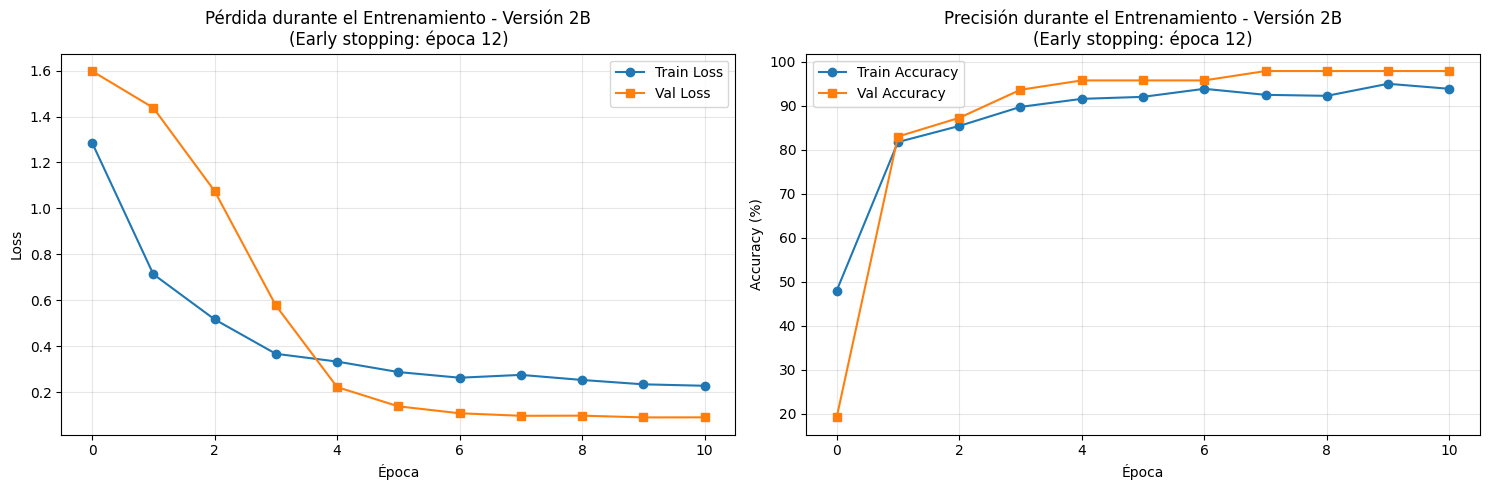

✅ Curvas de entrenamiento de la Versión 2B visualizadas!


In [68]:
# ==========================================
# CURVAS DE ENTRENAMIENTO - VERSIÓN 2B
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Loss
axes[0].plot(train_losses_v2b, label='Train Loss', marker='o')
axes[0].plot(val_losses_v2b, label='Val Loss', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Pérdida durante el Entrenamiento - Versión 2B\n(Early stopping: época {num_epochs_run_v2b})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de Accuracy
axes[1].plot(train_accs_v2b, label='Train Accuracy', marker='o')
axes[1].plot(val_accs_v2b, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title(f'Precisión durante el Entrenamiento - Versión 2B\n(Early stopping: época {num_epochs_run_v2b})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Curvas de entrenamiento de la Versión 2B visualizadas!")

In [69]:
# ==========================================
# EVALUACIÓN EN TEST SET - VERSIÓN 2B
# ==========================================

print("="*70)
print("EVALUACIÓN EN TEST SET - VERSIÓN 2B")
print("="*70)

# Evaluar en test
test_loss_v2b, test_acc_v2b = validate(model_v2b, test_loader, criterion_v2b, device)

print(f"\nTest Loss: {test_loss_v2b:.4f}")
print(f"Test Accuracy: {test_acc_v2b:.2f}%")
print("="*70)

EVALUACIÓN EN TEST SET - VERSIÓN 2B

Test Loss: 0.0989
Test Accuracy: 96.00%


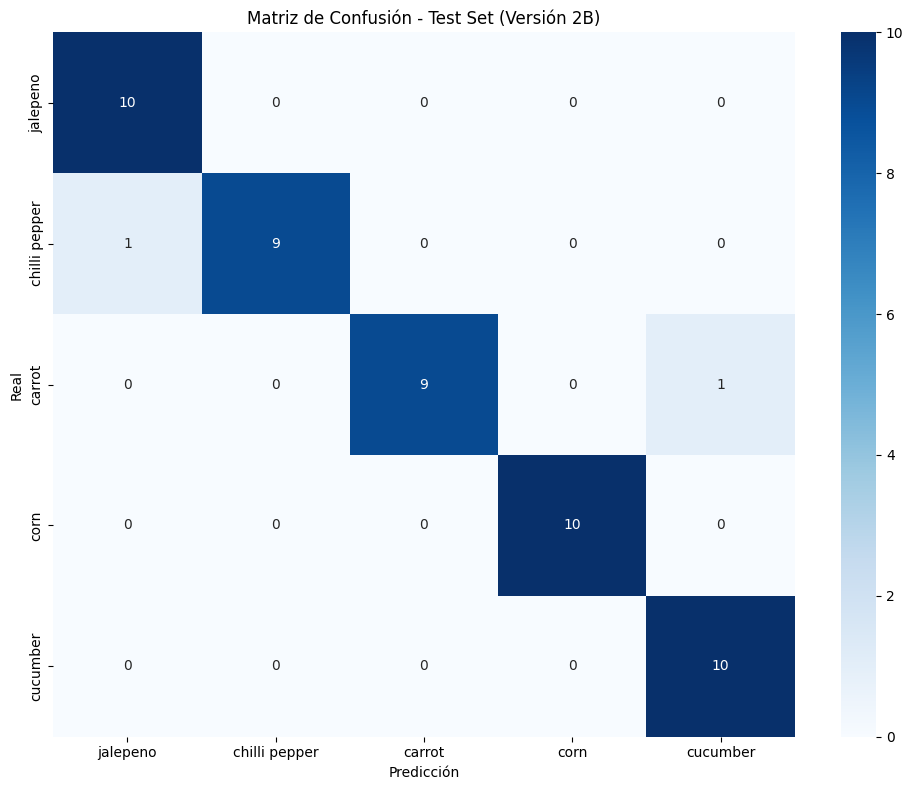


📊 REPORTE DE CLASIFICACIÓN - VERSIÓN 2B
               precision    recall  f1-score   support

     jalepeno     0.9091    1.0000    0.9524        10
chilli pepper     1.0000    0.9000    0.9474        10
       carrot     1.0000    0.9000    0.9474        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     0.9091    1.0000    0.9524        10

     accuracy                         0.9600        50
    macro avg     0.9636    0.9600    0.9599        50
 weighted avg     0.9636    0.9600    0.9599        50



In [70]:
# ==========================================
# MATRIZ DE CONFUSIÓN Y REPORTE - VERSIÓN 2B
# ==========================================

# Obtener predicciones en test set
model_v2b.eval()
all_preds_v2b = []
all_labels_v2b = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_v2b(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds_v2b.extend(predicted.cpu().numpy())
        all_labels_v2b.extend(labels.numpy())

# Crear matriz de confusión
cm_v2b = confusion_matrix(all_labels_v2b, all_preds_v2b)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_v2b, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test Set (Versión 2B)')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "="*70)
print("📊 REPORTE DE CLASIFICACIÓN - VERSIÓN 2B")
print("="*70)
print(classification_report(all_labels_v2b, all_preds_v2b, 
                          target_names=class_names, 
                          digits=4))
print("="*70)

In [71]:
# Guardar el modelo de la Versión 2B
torch.save({
    'model_state_dict': model_v2b.state_dict(),
    'optimizer_state_dict': optimizer_v2b.state_dict(),
    'train_losses': train_losses_v2b,
    'train_accs': train_accs_v2b,
    'val_losses': val_losses_v2b,
    'val_accs': val_accs_v2b,
    'test_acc': test_acc_v2b,
    'test_loss': test_loss_v2b,
    'class_names': class_names,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'version': '2B'
}, 'shufflenet_version_2b.pth')

print("✅ Modelo Versión 2B guardado como 'shufflenet_version_2b.pth'")

✅ Modelo Versión 2B guardado como 'shufflenet_version_2b.pth'
